# Merchant Recommendation
## SAL:
1. Definizione perimetro dati: <b>done</b>
2. Costruzione matrice di adiacenza per città di San Benedetto del Tronto: <b>done</b>
3. Training del modello senza covariate: <b>in progress</b>
 - Costruzione metriche di performance: <b>done</b>
 - Hyperparameter tuning: <b>in progress</b>
4. Costruzione matrici di informazioni covariate: <b>in progress</b>
5. Training del modello con covariate: <b>to do</b>
6. Inferenza e prediction: <b>to do</b>
7. Next steps: <b>to do</b>

In [1]:
!pip install pyathena
!pip install kneed

     |████████████████████████████████| 53 kB 3.2 MB/s  eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from esbmr2 import esbmr2
from hpf_vi import hpf_vi
from pyathena import connect
import boto3
import plotly.express as px
import plotly.offline as py
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import datetime
from IPython.display import display, HTML
from sklearn.cluster import KMeans
from kneed import KneeLocator
from sklearn.metrics import silhouette_score
from importlib import reload
from esbmr2 import esbmr2

# %% Importing custom modules
import train_test_split
import data_processing
import scoring
from CF import CF # importing the class for the heuristics

### Multiprocessing: prove basic

In [1]:
import pandas as pd
import numpy as np
import time
from functools import partial
import multiprocessing
from importlib import reload
# Custom modules
import multiprocessing_functions
reload(multiprocessing_functions)

appoggio = np.random.randn(1,10)

def matrix(a, b):
    new = np.empty(shape = a.shape)
    tic = time.time()
    for i in range(a.shape[0]):
        new[i,:] = a[i,:] ** b
    toc = time.time()
    print(toc-tic)
    return new

def row(a, b):
    return a ** b

row_partial = partial(row, b = 3)

def func_multi(df,
               n_proc=multiprocessing.cpu_count()):
    tic = time.time()
    df = multiprocessing_functions.multi_func_np(df,
                                                 func=row_partial,
                                                 n_procs=n_proc)
    toc = time.time()
    print(toc-tic)
    return df

func_multi(appoggio).shape
# matrix(appoggio, 3)  # 4.35

0.16192054748535156


(1, 10)

In [21]:
from multiprocessing import Pool
def quad(x):
    return x**2

res = map(quad, [1,2,3])

{1, 4, 9}


In [3]:
import pandas as pd
import numpy as np
import time
from functools import partial
import multiprocessing
from importlib import reload
# Custom modules
import multiprocessing_functions
reload(multiprocessing_functions)
from CF import CF

In [3]:
df = np.random.randn(100,100)

In [4]:
multiprocessing.cpu_count()

16

In [2]:
# !pip install rpy2 # trovare un workaround per AWS!

In [8]:
s3 = boto3.resource('s3')
s3_client = boto3.client('s3')
STAGING_BUCKET = 'nexi-tmp-athena-staging'
STAGING_AREA = 'tmp-athena-queries'
REGION_NAME = 'eu-west-1'
cursor = connect(s3_staging_dir="s3://{}/{}".format(STAGING_BUCKET,STAGING_AREA),
                 region_name=REGION_NAME,
                 work_group='WKGP-SM-DATA'
                ).cursor()
def runQueryFromString(sqlQuery):
    cursor.execute(sqlQuery)
    resultPath = cursor.output_location.replace('s3://','').split('/')
    try:
        obj = s3_client.get_object(Bucket=resultPath[0], Key=resultPath[1] + '/' + resultPath[2])
    except:
        return None
    return pd.read_csv(obj['Body'])

## Import dei dati
1. Interazioni carte-merchant con conteggio
2. Covariate carte
3. Covariate merchant

In [9]:
df = pd.read_csv("interazioni_sbt_2020_attivi.csv") 
df =  runQueryFromString("""
SELECT * FROM merch_recom.interazioni_sbt_2020_attivi
""")

In [2]:
# df = pd.read_csv("interazioni_sbt_2020_attivi.csv")

In [3]:
# Ottenimento valori binnati per il campo "conteggio" del DataFrame df:
# Nota: i bin vanno scelti di volta in volta in modo che non si sovrappongano. 
# I valori del parametro q vano bene per questo caso specifico (interazioni_sbt_2020_attivi)
# df = data_processing.make_bins(df, q=[0, .75, .85, .89, .95, 1])

# expl = data_processing.cross_tab_bins(df)

# train, test = train_test_split.train_val_split(expl)

In [10]:
# Alternative data manipulation: upper bound of 10 to 'conteggio'
reload(data_processing)
df['conteggio'][df['conteggio'] >= 10 ] = 10

expl = data_processing.cross_tab(df)

train, test = train_test_split.train_val_split(expl)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### Calcolo delle frequenze relative dei conteggi
Tali valori verranno utilizzati per binnare le prediction una volta avvenuto il training del modello.

In [11]:
conteggio_proportions = df.groupby('conteggio').count()['id_car']
conteggio_proportions = conteggio_proportions/conteggio_proportions.sum()
q = np.zeros(1) 
q = np.append(q, conteggio_proportions)
q

array([0.        , 0.63945205, 0.16493151, 0.07342466, 0.03561644,
       0.02575342, 0.01205479, 0.00657534, 0.0060274 , 0.00767123,
       0.02849315])

## Matrice di adiacenza
L'heatmap mostra il grado di interazione user-merchant. Il conteggio delle interazioni è stato normalizzato tra 0 e 5.

In [5]:
# Transazioni effettuate da singola carta (nel caso di implicit feedback)
# plt.hist(expl.sum(axis = 1))

In [12]:
#del model
model = esbmr2(prior_u = 'GN', prior_i = 'GN', gamma = 0.3, alpha_urn_u = 2.55, a = 1, b = 1)
model.fit(train, 10)
pred = model.predict(test)
"""
Il numero dei cluster è decrescente in a e crescente in b.
a=1,b=1: 2 cluster
a=0.1,b=1: più di 50 cluster

a=0.5,b=1: 15 cluster
a=0.5,b=5: 30 cluster
"""

------------------
Initial log-likelihood: -132127160.62255092
------------------
Gibbs Sampling simulation starts.
Iteration 0 complete. Log-likelihood: -132107730.91577318.
Runtime: 9.676258563995361
Block-interactions computed.
End: 1603450630.6971798


'\nIl numero dei cluster è decrescente in a e crescente in b.\na=1,b=1: 2 cluster\na=0.1,b=1: più di 50 cluster\n\na=0.5,b=1: 15 cluster\na=0.5,b=5: 30 cluster\n'

In [13]:
model.co_clustering_matrices()

## Community detection
### 1. Carte
Il modello individua 9 cluster di carte. Ciascun cluster è caratterizzato da diversi valori di interazione con i vari cluster dei merchant.

La stima basata su KMeans è leggermente discordante poiché individua meno cluster.

In [14]:
model.KMeans_estimator(method_u = "silhouette", method_i = "silhouette") # computes the KMeans estimator

In [18]:
# model.vi_estimator()
# np.unique(model.zu_est)
# model.zu_est_vi
# model.zu_est_kmeans

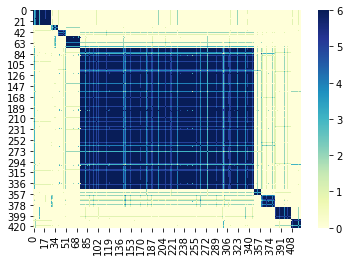

In [19]:
sns.heatmap(model.ccmatrix_u, cmap = 'YlGnBu')

### 2. Merchant
Il modello individua 12 cluster di merchant.

La stima basata su KMeans rileva 3 cluster. (!!!)

Rispetto alle carte, il clustering dei merchant appare più netto.

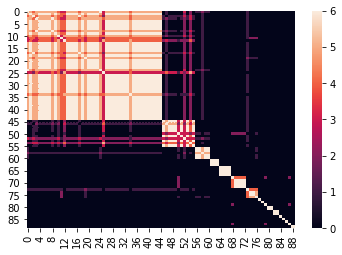

In [20]:
sns.heatmap(model.ccmatrix_i)

## Matrice di interazione carte-merchant
- L'heatmap riporta il grado di interazione normalizzato tra cluster di user e cluster di item.
- Le prediction si baseranno su tali valori

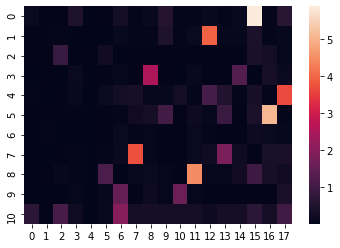

In [12]:
sns.heatmap(model.theta_est)

### Binning delle prediction
Ciò che ci interessa è che il modello sia in grado di riconoscere, nel caso multiclass, il livello di interazione tra una carte ed un merchant, piuttosto che il valore della prediction in sé. Pertanto assegniamo a ciascuna prediction uno dei 6 bin (da 0 a 5) e verifichiamo che essi non si discostino eccessivamente dal test set.
 

In [21]:
reload(data_processing)
predict = model.predict(test)
esbmr_pred = data_processing.make_bins_adjacency(predict, q=q.cumsum())
#predict_scaled = predict / predict.max() * 10
#predict_scaled = np.round(predict_scaled)

ValueError: Bin edges must be unique: array([0.0072904 , 0.03463993, 0.04347826, 0.08606856, 0.14545455,
       0.17090909, 0.17818182, 0.21493625, 0.21493625, 0.21493625,
       5.875     ]).
You can drop duplicate edges by setting the 'duplicates' kwarg

### Accuracy vs. Novelty
L'accuracy del modello "risente" della struttura a blocchi, che tuttavia si rivela utile per raccomandare novità agli utenti.

$Accuracy = \frac{\text{# correct predictions}}{\text{# total predictions}}$

In [17]:
reload(scoring)
score, cfpr, cfval = scoring.multiclass_accuracy(train, test, esbmr_pred)
score

0.6291672786018505

## Generare raccomandazioni
- La funzione <b>block recommend</b> ritorna i merchant suddivisi per cluster.

In [415]:
u1, u2 = 0,10
print(f" - Recommendations for user {u1}: ",model.block_recommend([0],5))
print(f" - Recommendations for user {u2}: ",model.block_recommend([10],5))

 - Recommendations for user 0:  {0: [array([[10]], dtype=int64), array([[45]], dtype=int64), array([[25]], dtype=int64), array([[86]], dtype=int64), array([[ 2],
       [35],
       [37]], dtype=int64)]}
 - Recommendations for user 10:  {10: [array([[27]], dtype=int64), array([[ 2],
       [35],
       [37]], dtype=int64), array([[19]], dtype=int64), array([[23]], dtype=int64), array([[25]], dtype=int64)]}


## Confronto con un'euristica: memory-based collaborative filtering
Un memory-based collaborative filtering è un algoritmo di raccomandazione basato unicamente su logiche algoritmiche. Non vi è dunque alcun fitting di modello. Il CF implementato è un CF user-based: le raccomandazioni per ciascuna carta sono la media aritmetica dei movimenti delle 10 carte più simili. 

In [18]:
cf = CF()
cf.fit(train, 10)

array([[1.1, 0. , 0.4, ..., 2.8, 0. , 0. ],
       [0.2, 0. , 0.4, ..., 2.4, 0. , 0. ],
       [1. , 0. , 1. , ..., 0.4, 0. , 0. ],
       ...,
       [1.2, 0. , 0. , ..., 3.3, 0. , 0. ],
       [1.1, 0. , 0. , ..., 2.4, 0. , 0. ],
       [0.2, 0. , 1.3, ..., 3.4, 0. , 0. ]])

In [49]:
cf_pred = cf.pred / cf.pred.max() * 5

In [50]:
cf_pred = np.round(cf_pred)

## Confronto con un modello concorrente: Hierarchical Poisson Factorization (HPF)
HPF è un latent feature model: al contrario dell'ESBMR, individua un vettore di feature per ciascuna carta e per ciascun merchant. Ciò si traduce in una elevata complessità modellistica, che limita le possibilità di fare inferenza dal modello.

Per i nostri dati, HPF genera 35890 parametri. ESBMR appena 104! Nonstante ciò, i due modelli hanno performance comparabili.

In [22]:
hpf = hpf_vi()
hpf.fit(expl,10, valid = test)

/home/ec2-user/SageMaker/dst-merchant-recommendation/hpf_vi.py:189: RuntimeWarning:

divide by zero encountered in log



Iteration 1 completed. Log-likelihood: -6387.304410651069
Iteration 2 completed. Log-likelihood: -5165.673697245566
Iteration 3 completed. Log-likelihood: -4987.492537428926
Iteration 4 completed. Log-likelihood: -4816.282892777231
Iteration 5 completed. Log-likelihood: -4682.384917311691
Iteration 6 completed. Log-likelihood: -4585.2879327532455
Iteration 7 completed. Log-likelihood: -4516.670516773062
Iteration 8 completed. Log-likelihood: -4465.015923404474
Iteration 9 completed. Log-likelihood: -4425.485094430815
Iteration 10 completed. Log-likelihood: -4395.526184510233
Stopped after 3.01 seconds, 10 iterations. Log-likelihood: -4395.526184510233.


In [46]:
pred = hpf.predicted / hpf.predicted.max() * 10

In [47]:
hpf_pred = np.round(pred)

In [48]:
scoring.multiclass_accuracy(train,test,hpf_pred)[0]

0.9092377735350272

In [36]:
from sklearn.metrics import accuracy_score
print(accuracy_score(test[test>2],esbmr_pred[test>2]))
print(accuracy_score(test[test>2],cf_pred[test>2]))
print(accuracy_score(test[test>2],hpf_pred[test>2]))

0.08333333333333333
0.0
0.0


Text(0.5, 1.0, 'Accuracy on high-valued interactions (more than 5)')

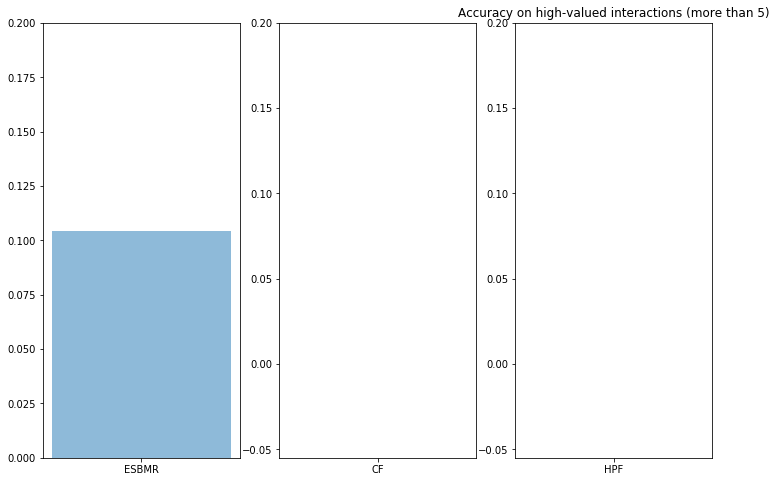

In [35]:
# Explicit feedback dataset
fig, ax = plt.subplots(figsize = (12,8), ncols = 3)

index = np.arange(3)
bar_width = 1

objects = ('ESBMR', 'HPF')
ax[0].bar("ESBMR", height = accuracy_score(test[test>3],esbmr_pred[test>3]), alpha = 0.5)
ax[0].set_ylim(top = 0.2)
ax[1].bar("CF", height = accuracy_score(test[test>3],cf_pred[test>3]), alpha = 0.5)
ax[1].set_ylim(top = 0.2)
ax[2].bar("HPF", height = accuracy_score(test[test>3],hpf_pred[test>3]), alpha = 0.5, color = "orange")
ax[2].set_ylim(top = 0.2)

plt.title('Accuracy on high-valued interactions (more than 2)')

# plt.show()

## Performance metrics
1. Mean squared Error (MSE): in-sample and out-of-sample
2. Accuracy score
3. Sensitivity: to do
3. Area under the ROC curve (AUC) - <i> for implicit feedback only </i>
4. Precision at-z

### 1. Mean Squared Error

In [38]:
reload(scoring)
scoring.mse(train, test, esbmr_pred) # rivedi

8.208841239535909

In-sample MSE. ESBMR: 4.3237111702366855. HPF: 4.093588629729193
Out-of-sample MSE. ESBMR: 3.3902801318456586. HPF: 3.3902801318456586


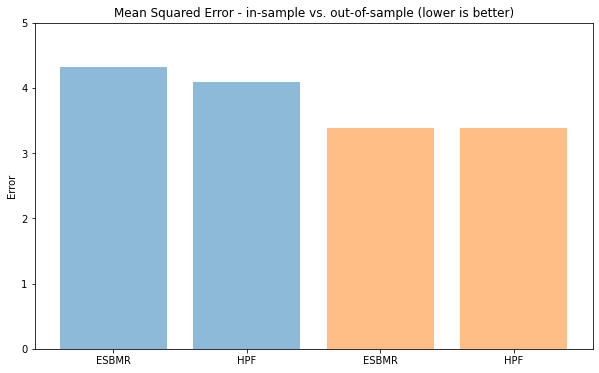

In [498]:
# Explicit feedback dataset
print(f"In-sample MSE. ESBMR: {model.mse(train, pred)}. HPF: {hpf.mse_train[hpf.mse_train.nonzero()[0][-1]]}")
print(f"Out-of-sample MSE. ESBMR: {model.mse(test, pred)}. HPF: {hpf.mse_valid[hpf.mse_valid.nonzero()[0][-1]]}")
fig, ax = plt.subplots(figsize = (10,6))

bar_width = 0.35
index = np.arange(2)
bar_width = 2

objects = ('ESBMR', 'HPF')
y_plot1 = [model.mse(train, pred),hpf.mse_train[hpf.mse_train.nonzero()[0][-1]]]
y_plot2 = [model.mse(test, pred),hpf.mse_valid[hpf.mse_valid.nonzero()[0][-1]]]
y_pos1 = np.arange(len(y_plot1))
plt.bar(index, y_plot1, align='center', alpha=0.5)
plt.bar(index + bar_width, y_plot2, align='center', alpha=0.5)
#plt.xticks(y_pos, objects)
plt.xticks([0,1,2,3], ('ESBMR', 'HPF','ESBMR', 'HPF'))
#plt.xticks(index + bar_width, ('ESBMR', 'HPF'))
plt.ylabel('Error')
plt.ylim(top = 5)
plt.title('Mean Squared Error - in-sample vs. out-of-sample (lower is better)')

plt.show()

### Stima delle interazioni: ground truth vs. estimated

Text(0.5, 0, 'Estimated interaction')

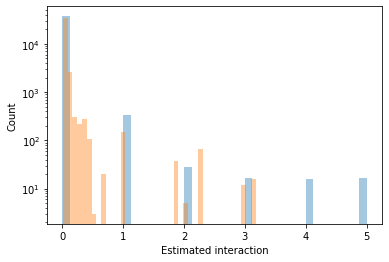

In [23]:
plt.hist(test.flatten(), bins = 40,alpha=0.4)
plt.hist(pred.flatten(), bins = 40, alpha = 0.4)
plt.yscale("log")
plt.ylabel("Count")
plt.xlabel("Estimated interaction")

### 3. Sensitivity
$Sensitivity = \frac{\text{#true positives}}{\text{total positives}}$

In [ ]:
# WIP

### 5. Precision-at-z: in progress
$    P_{z^*} = \frac{1}{U}\sum_{u=1}^{U}\frac{\textit{\# of items in $z_u^*$ that are relevant for $u$}}{K}
$

In [1]:
# model.block_recommend(range(train.shape[0]),1) # call to function
# recommended_and_relevant = 0
# precision = 0

## Implicit Feedback data
- Trasformiamo ora il dataset esplicito in un dataset implicito, ovvero con valori di interazione 0/1.

In [39]:
impl = expl.copy()
impl[expl.nonzero()] = 1

In [40]:
train_i, test_i = train_test_split.train_val_split(impl)

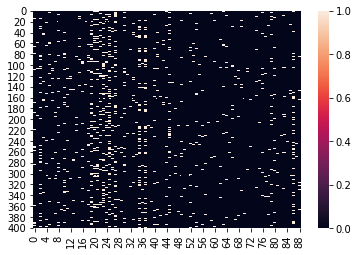

In [41]:
sns.heatmap(impl)

In [42]:
mod2 = esbmr2(prior_u = 'GN', prior_i = 'GN', gamma = 0.3, alpha_urn_u = 2.55, a = 0.3, b = 1)
mod2.fit(train_i, 30)

------------------
Initial log-likelihood: -6374.880060141051
------------------
Gibbs Sampling simulation starts.
Iteration 0 complete. Log-likelihood: -39437.35105458262.
Iteration 10 complete. Log-likelihood: -40373.8154466461.
Iteration 20 complete. Log-likelihood: -40362.577801036794.
Runtime: 14.411815881729126
Block-interactions computed.
End: 1603298784.3484879


In [44]:
pred_i = mod2.predict(test_i)

In [45]:
cf = CF()
cf.fit(train_i, 10)

array([[0.1, 0.2, 0.1, ..., 0.2, 0.1, 0. ],
       [0.2, 0. , 0.3, ..., 0.4, 0. , 0.1],
       [0.2, 0.2, 0.2, ..., 0.3, 0. , 0.1],
       ...,
       [0.2, 0.2, 0.2, ..., 0.3, 0. , 0.1],
       [0.1, 0.2, 0.1, ..., 0.1, 0. , 0. ],
       [0.1, 0.2, 0.1, ..., 0.2, 0. , 0. ]])

In [71]:
hpf2 = hpf_vi()
hpf2.fit(train_i, 10, valid = test_i)

/home/ec2-user/SageMaker/dst-merchant-recommendation/hpf_vi.py:189: RuntimeWarning:

divide by zero encountered in log



Iteration 1 completed. Log-likelihood: -4652.467650772923
Iteration 2 completed. Log-likelihood: -3284.1842317037804
Iteration 3 completed. Log-likelihood: -3127.906117166982
Iteration 4 completed. Log-likelihood: -2978.2736544962167
Iteration 5 completed. Log-likelihood: -2850.4816271844425
Iteration 6 completed. Log-likelihood: -2749.29749926991
Iteration 7 completed. Log-likelihood: -2673.815920035137
Iteration 8 completed. Log-likelihood: -2620.41035523825
Iteration 9 completed. Log-likelihood: -2584.8876013939207
Iteration 10 completed. Log-likelihood: -2562.5127465639293
Stopped after 1.96 seconds, 10 iterations. Log-likelihood: -2562.5127465639293.


In [51]:
pred_rand = np.random.randn(test.shape[0], test.shape[1])

In [69]:
scoring.roc_auc(train_i, test_i, pred_rand)

0.4731049434596577

L'accuracy è una misura del numero di prediction corrette sul numero totale di prediction (cardinalità del test set). Il threshold per l'accuracy è fissato al valore medio o mediano delle frequenze delle prediction.

In [72]:
reload(scoring)
print(f"Score for CF: {scoring.roc_auc(train_i, test_i, cf.pred)}")
print(f"Score for ESBMR: {scoring.roc_auc(train_i, test_i, pred_i)}")
print(f"Score for HPF: {scoring.roc_auc(train_i, test_i, hpf2.predicted)}")
print(f"Score for random: {scoring.roc_auc(train_i, test_i, pred_rand)}")

Score for CF: 0.6756528881418093
Score for ESBMR: 0.7354133557457212
Score for HPF: 0.7209865907701712
Score for random: 0.4782879355134474


### Distribuzione dell'AUC al variare del test set per i tre recommender system

(array([2., 2., 1., 3., 9., 5., 6., 6., 6., 3., 5., 2.]),
 array([0.46587561, 0.46727826, 0.46868092, 0.47008357, 0.47148622,
        0.47288887, 0.47429153, 0.47569418, 0.47709683, 0.47849948,
        0.47990214, 0.48130479, 0.48270744]),
 <a list of 12 Patch objects>)

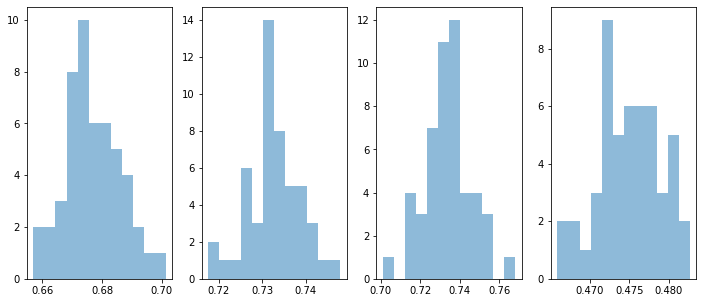

In [78]:
fig, ax = plt.subplots(figsize = (12,5), ncols = 4)

ax[0].hist([scoring.roc_auc(train_i,test_i, cf.pred) for i in range(50)], bins = 12, alpha = 0.5)
ax[1].hist([scoring.roc_auc(train_i,test_i, pred_i) for i in range(50)], bins = 12, alpha = 0.5)
ax[2].hist([scoring.roc_auc(train_i,test_i, hpf2.predicted) for i in range(50)], bins = 12, alpha = 0.5)
ax[3].hist([scoring.roc_auc(train_i,test_i, pred_rand) for i in range(50)], bins = 12, alpha = 0.5)

In [79]:
pred_i = pred_i / pred_i.max()

In [80]:
hpf2.predicted = hpf2.predicted / hpf2.predicted.max()

In [81]:
scoring.mse(train_i, test_i, pred_i)

0.053257111828440416

In-sample MSE. ESBMR: 0.7588364394011948. HPF: 0.6892397765345138
Out-of-sample MSE. ESBMR: 0.7979372002925533. HPF: 0.8556751329372552


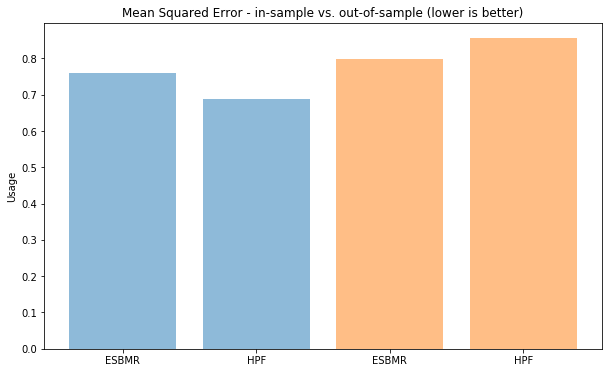

In [82]:
# OLD: UTILIZZA MODULO SCORING (come sopra), COSI' DA TENER CONTO DELLE TRASFORMAZIONI ALLE PREDICTIONS
print(f"In-sample MSE. ESBMR: {mod2.mse(train_i, pred_i)}. HPF: {hpf2.mse_train[hpf2.mse_train.nonzero()[0][-1]]}")
print(f"Out-of-sample MSE. ESBMR: {mod2.mse(test_i, pred_i)}. HPF: {hpf2.mse_valid[hpf2.mse_valid.nonzero()[0][-1]]}")

fig, ax = plt.subplots(figsize = (10,6))

bar_width = 0.35
index = np.arange(2)
bar_width = 2

objects = ('ESBMR', 'HPF')
y_plot1 = [mod2.mse(train_i, pred_i),hpf2.mse_train[hpf2.mse_train.nonzero()[0][-1]]]
y_plot2 = [mod2.mse(test_i, pred_i),hpf2.mse_valid[hpf2.mse_valid.nonzero()[0][-1]]]
y_pos1 = np.arange(len(y_plot1))
plt.bar(index, y_plot1, align='center', alpha=0.5)
plt.bar(index + bar_width, y_plot2, align='center', alpha=0.5)
#plt.xticks(y_pos, objects)
plt.xticks([0,1,2,3], ('ESBMR', 'HPF','ESBMR', 'HPF'))
#plt.xticks(index + bar_width, ('ESBMR', 'HPF'))
plt.ylabel('Usage')
plt.title('Mean Squared Error - in-sample vs. out-of-sample (lower is better)')

plt.show()

In [83]:
# OUT-OF-SAMPLE PERFORMANCE at a glance - better than random

# ESBMR 
print(pred_i[np.where(test_i == 1)].mean(), pred_i[np.where(test_i == 0)].mean())

# HPF
print(hpf2.predicted[np.where(test_i == 1)].mean(), hpf2.predicted[np.where(test_i == 0)].mean())

0.1131532425765632 0.04291832134403636
0.07525116819602479 0.03610927143465134


### Recommendations with binary data

In [577]:
u1, u2 = 0,10
print(f" - Recommendations for user {u1}: ",mod2.block_recommend([0],5))
print(f" - Recommendations for user {u2}: ",mod2.block_recommend([10],5))

 - Recommendations for user 0:  {0: [array([[19],
       [25],
       [27]], dtype=int64), array([[86]], dtype=int64), array([[33],
       [40],
       [45]], dtype=int64), array([[ 0],
       [ 8],
       [10],
       [11],
       [16],
       [22],
       [24],
       [26],
       [30],
       [52],
       [74],
       [79],
       [80],
       [88]], dtype=int64), array([[ 2],
       [23],
       [35],
       [37]], dtype=int64)]}
 - Recommendations for user 10:  {10: [array([[19],
       [25],
       [27]], dtype=int64), array([[86]], dtype=int64), array([[33],
       [40],
       [45]], dtype=int64), array([[ 0],
       [ 8],
       [10],
       [11],
       [16],
       [22],
       [24],
       [26],
       [30],
       [52],
       [74],
       [79],
       [80],
       [88]], dtype=int64), array([[ 2],
       [23],
       [35],
       [37]], dtype=int64)]}


In [84]:
mod2.precision_at_z(test_i, pred_i, threshold = 0.0)

0.0628428927680798

In [85]:
mod2.recall_at_z(test_i, pred_i, threshold = 0.1)

0.25257731958762886

In [594]:
# Recall much higher than precision: as expected, since the model is based on a block structure, 
# it will suggest many items that are in line with the preference of the user, but that the user never consumed.
# Hence, on the one hand, we get a relatively low precision-at-z.
# On the other hand, a high recall confirms that the model detects a high proportion of relevant items on the total.

In [86]:
reload(scoring)
a, b, c = scoring.accuracy(train_i, test_i, pred_i, 0.1)
a

0.37897310513447435

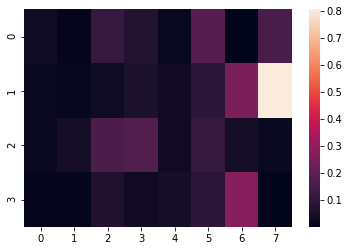

In [87]:
sns.heatmap(mod2.theta_est)

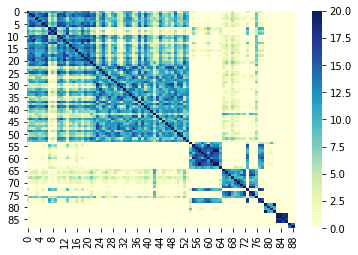

In [88]:
mod2.co_clustering_matrices()
sns.heatmap(mod2.ccmatrix_i, cmap = 'YlGnBu')

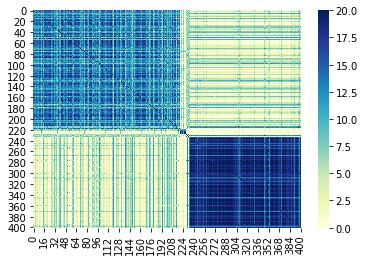

In [89]:
sns.heatmap(mod2.ccmatrix_u, cmap = 'YlGnBu')

## Aggiunta di informazioni nodali come covariate

### Implementazione stimatore cluster assignment basato su posterior similarity matrix
(si veda codice)